# Checkpoint B

 ## What is the question(s) you are attempting to answer with your business analytics project?
    The main question I want to answer is how did the economy in El Paso behave during and after the COVID-19 Pandemic, and at what point did it return to normal levels or what, if any, were the long terms effects on it. 
## What is the dataset(s) will you use for your project?
    The data I'm using is a mixture of datasets put together by the Opportunity Insights Economic Tracker Project, based on a research article built and maintained throughout the pandemic: "The Economic Impacts of COVID-19: Evidence from a New Public Database Built Using Private Sector Data", by Raj Chetty, John Friedman, Nathaniel Hendren, Michael Stepner, and the Opportunity Insights Team. November 2020. Available at: https://opportunityinsights.org/wp-content/uploads/2020/05/tracker_paper.pdf"
    Specifically, I'm using Affinity, Lightcast, CDC, Google, and Paycheck data sources, which have been aggregated and made available by the authors of the previously mentioned project.     
 ## Provide a refined version of the table from checkpoint A that describes the columns of the datasets you plan to use. If you have not done so, add a column to describe the data type each column captures

In [31]:
# Table / Dataframe
from tabulate import  tabulate
Columns = {
  'Source': ["Affinity", "Affinity", "Lightcast", "CDC","CDC", "Google", "Paycheck", "GeoIDs"],
  'Column_name': ['spend_all', "spend_inperson", 'bg_posts', 'new_case_rate', 'new_vaccine_rate', 'gps_away_from_home', "emp_incq1", "cityid"],
  'Description': ["Spending in all merchant category codes (MCCs)",  "Spending in in-person services (ACF, HCS, AER, TWS, REN, REP, PLS) MCCs.","Average level of job postings relative to January 4 to 31, 2020.", "New confirmed COVID-19 cases per 100,000 people, seven day rolling sum", " First vaccine doses administered per 100 people", "Time spent outside of residential locations", "Employment level for workers in the bottom quartile of the wage distribution (annualized wage lower than the federal poverty line).","The city identifier that the county is assigned to"],
  'Note':[" ","ACF accomodation and food services; HCS healthcare and social assistance; AER arts, entertainment, and recreation; TWS transportation and warehousing;REN rental and leasing; REP repair and maintenance; and PLS personal and laundry services", " ", " ", " ", " ", " ", " "] 
}
#print(len(Columns['Source']), len(Columns['Column_name']), len(Columns['Description']), len(Columns['Note']))
columns_df = pd.DataFrame.from_dict(Columns)
print(tabulate(columns_df, headers='keys', tablefmt='psql'))


+----+-----------+--------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Source    | Column_name        | Description                                                                                                                         | Note                                                                                                                                                                                                                                            |
|----+-----------+--------------------+---------------------------------------------------------------------------------------------------------------------------------

## Conduct an initial descriptive analysis. Identify five things your data has that need attention or are valuable to your project (e.g., problems, opportunities).
    1. Because I'm using several csv files, I need to merge them to do meaningful analysis. In this checkpoint, I did that and it took a while to debug. It will be time-consuming.
    2. Empty values are marked by a period/dot. I need to change them to NA and then convert to float data types to be able to use them in calculations and plots. I did this for one column in this checkpoint, and I will need to use it for the rest most likely.
    3. The year, month, day need to be converted to datetime object to be able to plot easier for all of them. Did it on one in this checkpoint.
    4. The cityid being standardized across all files is very useful. I just needed to identify what number El Paso was so I could filter every dataset based on that.
    5. Timeseries will be a pillar here, as the objective of the analysis is to see economic resurgance across time.   
## Describe with bullet points your plan to conduct predictive analytics.
    1. Do a machine learning algorithm to predict the new vaccine rate effect on the spending of in-person activities.
    2. Do a classification model to try to guess how many new cases would show up based on the time spent outside of residential locations.
    3. Time-Series predictive models of level of job postings using Tableau, perhaps.

# Explorative Descriptive Statistics Section

In [60]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # Removing an annoying warning

### Reading files

In [33]:
covid_data = pd.read_csv('COVID - City - Daily.csv')
spending_data = pd.read_csv('Affinity - City - Daily.csv')
employment_data = pd.read_csv('Employment - City - Weekly.csv')
geo = pd.read_csv('GeoIDs - City.csv')
mobility_data = pd.read_csv('Google Mobility - City - Daily.csv')
jobs_data = pd.read_csv('Job Postings - City - Weekly.csv')
milestones_data = pd.read_csv('Policy Milestones - State.csv')

In [34]:
geo.head(2)
geo[geo['cityname'] == 'El Paso']

,cityid,cityname,stateabbrev,statename,statefips,lat,lon,city_pop2019
21,22,El Paso,TX,Texas,48,31.78,-106.44,839238


### The city of El Paso is #22 in column cityid, which is used across the source files.

In [35]:
mobility_data = mobility_data[mobility_data['cityid'] == 22]
covid_data = covid_data[covid_data['cityid'] == 22]
spending_data = spending_data[spending_data['cityid'] == 22]
jobs_data = jobs_data[jobs_data['cityid'] == 22]
employment_data = employment_data[employment_data['cityid'] == 22]

## Merging every dataset I need

In [51]:
first_merge = covid_data.merge(mobility_data, on=['year', 'month','day', 'cityid'], how='left')
second_merge = first_merge.merge(spending_data, on=['year', 'month','day', 'cityid'], how='left')
third_merge = second_merge.merge(jobs_data, on=['year', 'month','cityid'], how='left')
final_merge = third_merge.merge(employment_data, on=['year', 'month', 'cityid'], how='left')
final_merge

,year,month,day,cityid,case_count,death_count,new_case_count,new_death_count,vaccine_count,new_vaccine_count,...,bg_posts_jz5,day_endofweek_y,emp,emp_incq1,emp_incq2,emp_incq3,emp_incq4,emp_incmiddle,emp_incbelowmed,emp_incabovemed
0,2020,1,1,22,.,.,.,.,.,.,...,.,17,-.00169,-.00732,.016,-.0019,-.00756,.0114,-.00116,.
1,2020,1,1,22,.,.,.,.,.,.,...,.,24,.0023,-.00168,.0184,-.00406,-.00606,.0126,.00361,.
2,2020,1,1,22,.,.,.,.,.,.,...,.,31,.00621,.00973,-.0114,.0276,.00714,-.00133,.00417,.
3,2020,1,1,22,.,.,.,.,.,.,...,.,17,-.00169,-.00732,.016,-.0019,-.00756,.0114,-.00116,.
4,2020,1,1,22,.,.,.,.,.,.,...,.,24,.0023,-.00168,.0184,-.00406,-.00606,.0126,.00361,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23087,2023,5,10,22,.,.,.,.,986160,369,...,.,26,.0897,.0904,-.0289,.591,.,.131,.0589,.
23088,2023,5,10,22,.,.,.,.,986160,369,...,.,5,.194,.254,-.0311,.567,.,.123,.179,.
23089,2023,5,10,22,.,.,.,.,986160,369,...,.,12,.194,.256,-.0331,.57,.,.122,.18,.
23090,2023,5,10,22,.,.,.,.,986160,369,...,.,19,.157,.205,-.0407,.579,.,.119,.14,.


### Converting to datetime

In [52]:
final_merge['datetime'] = pd.to_datetime(dict(year=final_merge.year, month=final_merge.month, day=final_merge.day))

## Final DF

In [55]:
final_df = final_merge[['datetime', 'cityid', 'spend_all', "spend_inperson", 'bg_posts', 'new_case_rate', 'new_vaccine_rate', 'gps_away_from_home', 'emp_incq1']]

,datetime,cityid,spend_all,spend_inperson,bg_posts,new_case_rate,new_vaccine_rate,gps_away_from_home,emp_incq1
0,2020-01-01,22,.,.,.,.,.,NaN,-.00732
1,2020-01-01,22,.,.,.,.,.,NaN,-.00168
2,2020-01-01,22,.,.,.,.,.,NaN,.00973
3,2020-01-01,22,.,.,.,.,.,NaN,-.00732
4,2020-01-01,22,.,.,.,.,.,NaN,-.00168
...,...,...,...,...,...,...,...,...,...
23087,2023-05-10,22,NaN,NaN,-0.221,.,.0439,NaN,.0904
23088,2023-05-10,22,NaN,NaN,-0.0951,.,.0439,NaN,.254
23089,2023-05-10,22,NaN,NaN,-0.0951,.,.0439,NaN,.256
23090,2023-05-10,22,NaN,NaN,-0.0951,.,.0439,NaN,.205


### Replacing dots with NA and converting to numeric

In [65]:
final_df['spend_all'] = final_df['spend_all'].replace('.', pd.NaT)
final_df['spend_all'] = pd.to_numeric(final_df['spend_all'], errors='coerce')

final_df['spend_inperson'] = final_df['spend_inperson'].replace('.', pd.NaT)
final_df['spend_inperson'] = pd.to_numeric(final_df['spend_inperson'], errors='coerce')

final_df['bg_posts'] = final_df['bg_posts'].replace('.', pd.NaT)
final_df['bg_posts'] = pd.to_numeric(final_df['bg_posts'], errors='coerce')

final_df['new_case_rate'] = final_df['new_case_rate'].replace('.', pd.NaT)
final_df['new_case_rate'] = pd.to_numeric(final_df['new_case_rate'], errors='coerce')

final_df['new_vaccine_rate'] = final_df['new_vaccine_rate'].replace('.', pd.NaT)
final_df['new_vaccine_rate'] = pd.to_numeric(final_df['new_vaccine_rate'], errors='coerce')

final_df['gps_away_from_home'] = final_df['gps_away_from_home'].replace('.', pd.NaT)
final_df['gps_away_from_home'] = pd.to_numeric(final_df['gps_away_from_home'], errors='coerce')

final_df['emp_incq1'] = final_df['emp_incq1'].replace('.', pd.NaT)
final_df['emp_incq1'] = pd.to_numeric(final_df['emp_incq1'], errors='coerce')

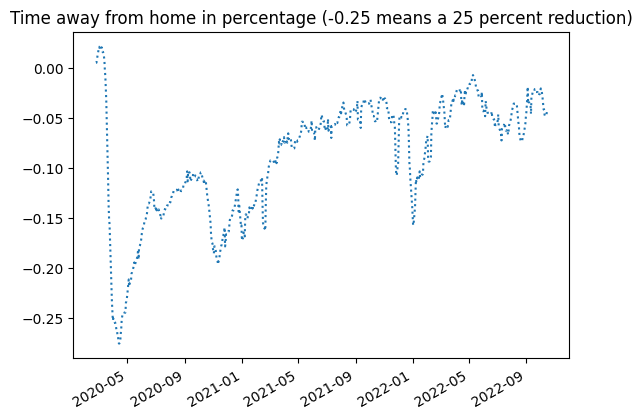

In [68]:
plt.plot(final_df['datetime'], final_df['gps_away_from_home'], linestyle='dotted')
plt.title('Time away from home in percentage (-0.25 means a 25 percent reduction)')
plt.gcf().autofmt_xdate()
plt.show()

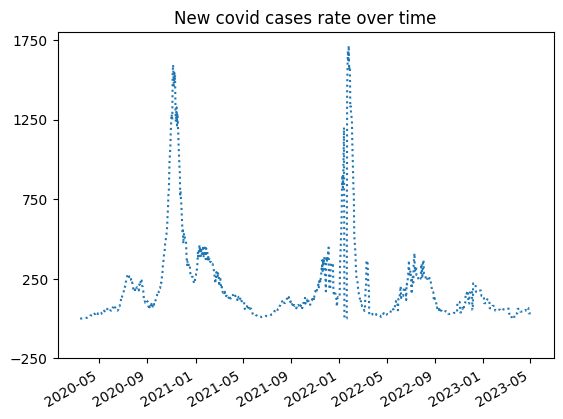

In [71]:
plt.plot(final_df['datetime'], final_df['new_case_rate'], linestyle='dotted')
plt.title('New covid cases rate over time')
plt.gcf().autofmt_xdate()
ax = plt.gca()
ax.set_yticks(ax.get_yticks()[::2])
plt.show()

# End of Data Cleaning, exporting final_df for a cleaner final report

In [72]:
final_df.to_csv('final_df.csv', index=False)